#### Useful Julia packages

Below is a list of Julia packages you might find useful:
- [DifferentialEquations.jl](???) :
- [Plots.jl](???) : 
- [Pyplot.jl](???) :
- [StatsBase.jl](???) :
- [StatsPlots.jl](???):
- [LaTeXStrings.jl](???) :

To install them, do as in the cell below.

In [1]:
# --> Pkg is the Julia package manager.
using Pkg

# --> Installing DifferentialEquations.jl
Pkg.add("DifferentialEquations")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — /home/jean-christophe/.julia/registries/General — failed to fetch from repo
└ @ Pkg.API /home/conda/feedstock_root/build_artifacts/julia_1545835397065/work/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:157


 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
# --> Basic linear algebra.
using LinearAlgebra

# --> ODE and SDE solvers.
using DifferentialEquations

# --> Plotting library. Matplotlib backend.
using Plots; pyplot()

# --> Statistical packages.
using StatPlots
using StatsBase

# --> Enable LaTeX labels in figures.
using LaTeXStrings

# Stochastic ain't chaotic

The aim of this project is to study the long-time behaviour of a dynamical system under white noise excitation. For that purpose, there are three different approaches you can use:
- Fokker Planck equation,
- Monte-Carlo simulations,
- Cumulant equations.

It is strongly suggested that you use at least two of these methods and compare their pros and cons. The rest of this notebook is dedicated to illustrating how to setup a stochastic simulation of the following system

$$
    \dot{x} = rx - x^3 + \gamma \eta
$$

with $x \in \mathbb{R}$ being the state of the system, while the external white noise excitation $\eta$ has covariance $\gamma$.

### Deterministic case

Let us first consider the noiseless case (i.e. $\gamma=0$). The equation we aim to solve is thus

$$
    \dot{x} = rx - x^3
$$

with initial condition $x(0) = x_0$ and $r=10^{-6}$ for instance. The following cells illustrate how to solve this problem in Julia.

In [37]:
# --> Define the parameters of the problem.
r = 0.1     # Control parameter.
x₀ = 1e-6   # Initial condition.
tspan = (0.0, 500.0)     # Integrate from t=0 up to t=100.

# --> Creates the Julia function for the right-hand side function.
f(x, p, t) = r*x - x^3

# --> Set up the problem to be handle to DifferentialEquations.jl
prob = ODEProblem(f, x₀, tspan)

# --> Solve the problem.
sol = solve(prob, alg=Tsit5());

Let us now plot the simulated solution $x(t)$.

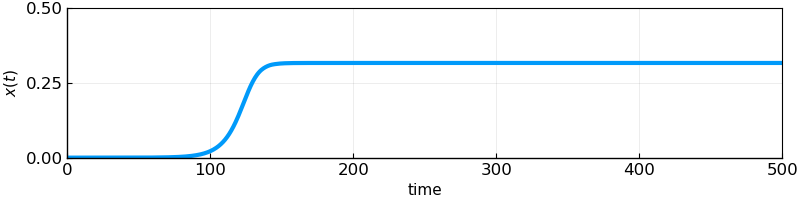

In [39]:
# --> Plot the solution.
plot(
    sol, vars = (0, 1), 
    xlabel = "time", tickfont = 12,
    ylim = (0, 0.5), yticks = 0:0.25:0.5, ylabel = L"$x(t)$",
    framestyle = :box,
    size = (800, 200), # In pixels.
    legend = :none
)

There are a lot of different options you can tweak to make the figure looks nicer (although this is essentially personal taste). For more details, you can look at the different tutorials and the documentation from [Plots.jl](???).

### Stochastic simulation

Let us now reconsider our original stochastically-forced dynamical system and let see how to implement in Julia using [DifferentialEquations.jl](???).

In [122]:
# --> Define the parameters of the problem.
r = 0.1     # Control parameter.
x₀ = 1e-6   # Initial condition.
tspan = (0.0, 20000.0)     # Integrate from t=0 up to t=100.

# --> Deterministic component of the system.
f(x, p, t) = r*x - x^3

# --> Stochastic component of the system.
γ = 0.05 # Covariance of the noise.
g(x, p, t) = γ

# --> Set up the problem to be handle to DifferentialEquations.jl
prob = SDEProblem(f, g, x₀, tspan)

# --> Solve the problem.
sol = solve(prob, alg=SRIW1());
sol_bis = solve(prob, alg=SRIW1());

Note that, because we now have a stochastic forcing, we can no longer use standard time-integrators such as Runge-Kutta. Instead, [DifferentialEquations.jl](???) has a number of high-order stochastic time-integrators already implemented such as SRIW1 (???). The two cells below illustrate how to plot the corresponding time-series of $x(t)$ for the two simulations we just ran and how to plot the empirical probability density function estimated from these time-series. When estimating a PDF from time-series, make sure that your time-series is long enough as to converge your statistics.

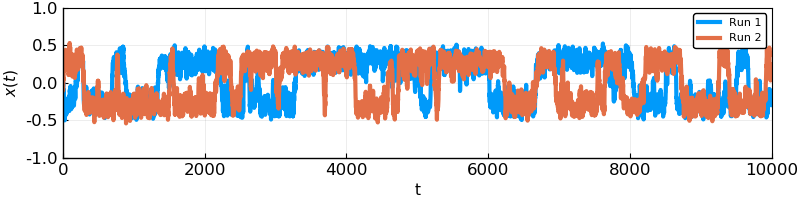

In [134]:
# --> Plot the solution.
plot(
    sol, vars = (0, 1), 
    xlim = (0, 10000), xlabel = "time", tickfont = 12,
    ylabel = L"$x(t)$",
    framestyle = :box,
    size = (800, 200), # In pixels.
    label = "Run 1",
)

# --> Add the second solution on the plot.
plot!(
    sol_bis, vars = (0, 1),
    xlim = (0, 10000),
    ylim = (-1, 1), yticks = -1:0.5:1,
    label = "Run 2",
    legend = :topright
)

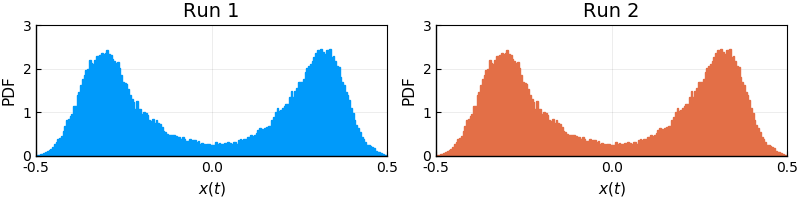

In [124]:
# --> Get the time points at which to atually evaluate the solutions.
t = collect(tspan[1]:0.1:tspan[2])

# --> Evaluate the solution.
z = sol(t);

# --> Construct a histogram to approximate the empirical probability density function.
h = fit(Histogram, z, nbins=250)
h = normalize(h, mode=:pdf)

# --> Get the maximum of the PDF to set the y-axis limits.
ymax = ceil(maximum(h.weights))

# --> Plot the empirical PDF of the first run.
p1 = plot(
    h,
    ylim = (0, ymax), ylabel = "PDF", tickfont = 10,
    xlim = (-0.5, 0.5), xticks = -0.5:0.5:0.5, xlabel = L"$x(t)$",
    size = (200, 200),
    framestyle = :box,
    color = 1, linecolor = :match,
    linewidth = 1,
    legend = :none,
    title = "Run 1"
)

# --> Plot the empirical PDF of the second run.
z_bis = sol_bis(t);

# --> Construct a histogram to approximate the empirical probability density function.
h_bis = fit(Histogram, z_bis, nbins=250)
h_bis = normalize(h_bis, mode=:pdf)

p2 = plot(
    h,
    ylim = (0, ymax), ylabel = "PDF", tickfont = 10,
    xlim = (-0.5, 0.5), xticks = -0.5:0.5:0.5, xlabel = L"$x(t)$",
    size = (200, 200),
    framestyle = :box,
    color = 2, linecolor = :match,
    linewidth = 1,
    title = "Run 2",
    legend = :none,
)


# --> Combine the two subplots into one single plot.
plot(
    p1, p2,
    layout = (1, 2),
    size = (800, 200)
)

# Project

The equation you'll be working with during this project is the following

$$
    \dot{x} = \mu x + \beta_1 x^3 - \beta_2 x^5 + \epsilon + \gamma \eta.
$$

with $x \in \mathbb{R}$ being the state of the system at time $t$ while $\mu$, $\beta_1$ and $\beta_2$ are real-valued control parameters (with $\beta_1, \beta_2 > 0$). The parameter $\epsilon$ corresponds to a small imperfection in the system possibly breaking its symmetry. Finally, $\gamma$ is the variance of the external white noise $\eta$ driving the system. Such a stochastic dynamical system is an extreme simplification of the problem of subcritical transition to turbulence in fluid dynamics. It nonetheless exhibits some of the key aspects of this fundamental problem.

Below is a non-exhaustive list of investigations you can do for this project:
- Fully characterize the dynamics and bifurcation diagram of the deterministic system (with/without imperfection $\epsilon$) as you vary the control parameter $\mu$.
- Investigate the dynamics of the system under white noise excitation in the region of the parameter space for which 5 fixed points co-exist. Depending on the amplitude of the white noise excitation, how does the residence time around each fixed point evolve?
- For a given amplitude of the white noise excitation, how does the probability density function of the system evolves as $\mu$ varies? (e.g. bifurcation diagram of the PDF itself).
- What if you change from white noise excitation to colored noise?